# Testing Notebook

After training the model at [train.ipynb](https://github.com/ammar-elsabe/handwritten-digit-recognition-DCNN/blob/master/src/train.ipynb) we need to test its accuracy

## Imports

We begin by importing our dependencies, for testing, we need tensorflow and tensorflow_datasets much like we did with training, but we also need numpy and seaborn

In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## The dataset
We use the [load](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method to load the mnist dataset, but this time, we only load the test split which contains 10000 images

In [ ]:
# load the mnist dataset
dstest, dsinfo = tfds.load(
    'mnist',
    split=['test'],  # only need the test set
    data_dir='../dataset/',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

dstest = dstest[0] # Because tfds.load returns a list


## Preprocessing

We follow the same preprocessing we did while training the model, which is practically nothing that is necessary. However for performance reasons, we autotune and batch the test set

In [3]:
batch_size = 128

# Evaluation pipleine
dstest = dstest.batch(batch_size)
dstest = dstest.cache()
dstest = dstest.prefetch(tf.data.AUTOTUNE)

## The model

We load the model created in the train script

In [4]:
model = tf.keras.models.load_model('./model.h5')

Printing the class names

In [5]:
class_names = dsinfo.features['label'].names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Generating the model predictions

In [6]:
model_probabilities = model.predict(dstest)
pprint(model_probabilities)

2022-04-24 23:30:08.887871: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


array([[1.3535260e-12, 9.2269102e-11, 1.0000000e+00, ..., 1.2002113e-10,
        3.6733475e-08, 1.2856706e-10],
       [9.9999809e-01, 1.9031241e-09, 3.8650558e-08, ..., 4.1776258e-07,
        1.7634169e-07, 8.7255484e-07],
       [1.0604630e-11, 4.1063618e-08, 1.8023245e-09, ..., 8.3668425e-07,
        8.0477860e-11, 7.3748092e-09],
       ...,
       [1.1503052e-11, 2.6557379e-10, 5.7338542e-07, ..., 1.2051790e-10,
        9.9999917e-01, 2.3892071e-07],
       [9.9994540e-01, 1.3106036e-07, 2.7527710e-08, ..., 6.4490371e-07,
        3.2164176e-09, 5.1208815e-05],
       [1.8934915e-10, 3.5097508e-10, 2.8572342e-11, ..., 4.0571066e-12,
        3.7729077e-08, 2.4009706e-08]], dtype=float32)


`model.predict ` returns a list of lists, where each inner list contains the probabilities that image belongs to each class, to get the predicted labels we choose the class with the highest probability

In [7]:
predictions = [np.argmax(x) for x in model_probabilities]
pprint(predictions[:10]) # printing the last 10 results

[2, 0, 4, 8, 7, 6, 0, 6, 3, 1]


## Evaluation of the model
We get the actual true labels using this one line

In [8]:
labels = np.concatenate([y for x, y in dstest], axis=0)

We then generate a confusion matrix and plot it

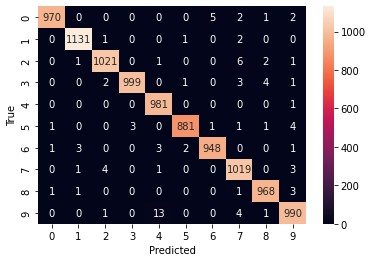

In [9]:
confusion_matrix = tf.math.confusion_matrix(
    labels=labels,
    predictions=predictions,
)
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=class_names,
            yticklabels=class_names,
            fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('../paper/figs/confusion_matrix.svg', format='svg')
plt.show()

With the confusion matrix we can calculate the accurace as
$$
\frac{\sum_{i = 0}^9 k_{ii}}{\sum_{i = 0}^9 \sum_{j = 0}^9 k_{ij}} \times 100
$$

Where $k_{xy}$ represent an element in the $x^{th}$ row and the $y^{th}$ column in the confusion matrix, in other words it is the sum of the elements in the diagonal of the confusion matrix, dividied by the total sum.

In [10]:
diagonal_sum = 0
total_sum = 0

for i in range(len(class_names)):
    for j in range(len(class_names)):
        if(i == j):
            diagonal_sum += confusion_matrix[i][j]
        total_sum += confusion_matrix[i][j]

print("Diagonal sum: {}, Total sum: {}".format(diagonal_sum, total_sum)) # total sum should be 10000 as the test split is 10000 images
accuracy = 100 * diagonal_sum/total_sum
print("Accuracy: {}".format(accuracy))

Diagonal sum: 9908, Total sum: 10000
Accuracy: 99.08


We can also calculate the per-digit accuracy for a digit $i$ as
$$
\frac{k_{ii}}{\sum_{j = 0}^9 k_{ij}} \times 100
$$
(For example, for the digit $0$, it was predicted correctly $970$ times out of $976 + 0 + 0 + 0 + 0 + 0 + 5 + 2 + 1 + 2$)
With that information, we can plot a bar chart to see how accurately our model predicts each digit with the following code

/tmp/ipykernel_24732/3498705007.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


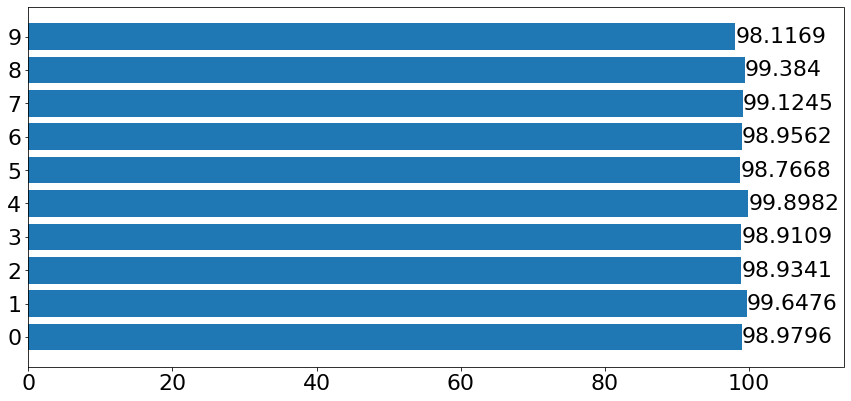

In [12]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 0.7, 1])
digits = list(range(0, 10))
digit_acc = []
for i in digits:
    row_sum = sum([confusion_matrix[i][j] for j in digits])
    digit_acc.append(100 * confusion_matrix[i][i]/row_sum)
plt.yticks(digits)
bars = ax.barh(digits, digit_acc)
ax.bar_label(bars)
ax.spines["top"].set_bounds(0,113)
ax.spines["bottom"].set_bounds(0,113)
ax.spines["right"].set_position(("outward", 60))
plt.rcParams.update({'font.size': 22}) # Increasing the text size
fig.tight_layout()
plt.savefig('../paper/figs/bar_plot.svg', format='svg', bbox_inches='tight')
plt.show()